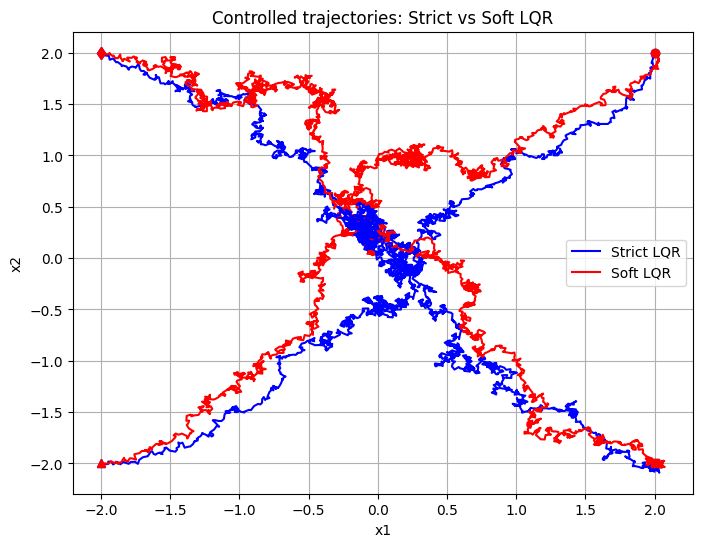

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def solve_riccati_strict(H, M, C, D, R_terminal, T, dt):
    """
    计算“严格 LQR(Strict LQR)”的 Riccati 方程：
        dS/dt = S M D^{-1} M^T S - H^T S - S H - C,  S(T) = R_terminal

    这里使用欧拉法(Backward Euler)在离散网格上从 t=T 反向到 t=0。
    """
    # 计算离散步数 N
    N = int(T/dt)

    # 系统是 2×2，因此 n=2
    n = H.shape[0]

    # 用一个三维数组存储每个时间步的 S(t)，大小 (N+1, n, n)
    S_list = np.zeros((N+1, n, n))

    # 终端条件：S(T) = R_terminal
    S_list[N] = R_terminal

    # 预先计算 D^{-1}，因为后面要多次用到
    D_inv = np.linalg.inv(D)

    # 逆序遍历，从 k=N-1 一直走到 k=0
    for k in reversed(range(N)):
        # S_next 表示 S(t+dt)，也就是“下一个”时间步的 S
        S_next = S_list[k+1]

        # quad = S_next * M * D^{-1} * M^T * S_next
        # 这是 S M D^{-1} M^T S 的中间量
        quad = S_next @ M @ D_inv @ M.T @ S_next

        # dS/dt = quad - H^T S - S H - C
        # 这里把右边直接记为 dS (只是为了方便表示)
        dS = quad - H.T @ S_next - S_next @ H - C

        # 反向欧拉：S(t) = S(t+dt) - dt * dS
        S_new = S_next - dt * dS

        # 由于数值计算会有微小误差，强制对称化
        S_list[k] = 0.5 * (S_new + S_new.T)

    return S_list


def solve_riccati_soft(H, M, C, D, R_terminal, T, dt):
    """
    计算“软 LQR(Soft LQR)”的 Riccati 方程：
        dS/dt = 2 * S M D^{-1} M^T S - H^T S - S H - C,  S(T) = R_terminal

    对比严格 LQR，多了一个“2”系数，源于熵正则项(即“软化”控制)。
    同样使用欧拉法(Backward Euler)从 t=T 反向到 t=0。
    """
    N = int(T/dt)
    n = H.shape[0]
    S_list = np.zeros((N+1, n, n))

    # 终端条件
    S_list[N] = R_terminal

    D_inv = np.linalg.inv(D)

    for k in reversed(range(N)):
        S_next = S_list[k+1]
        quad = S_next @ M @ D_inv @ M.T @ S_next

        # 与严格 LQR 的唯一区别：控制项前面多了一个“2”
        dS = 2 * quad - H.T @ S_next - S_next @ H - C

        S_new = S_next - dt * dS
        # 强制对称
        S_list[k] = 0.5 * (S_new + S_new.T)

    return S_list


def simulate_strict(H, M, D, S_list, x0, T, dt, sigma, seed=0):
    """
    在“严格 LQR”反馈控制下模拟系统轨迹：
      dX = (H Xs + M α) dt + sigma dW
    其中最优控制 α = - D^{-1} M^T S(t) X(t)，是确定性的。
    """
    # 为保证可重复，设定随机数种子
    np.random.seed(seed)

    # 离散步数
    N = int(T/dt)
    n = H.shape[0]

    # x_traj 用于存储每个时间步的状态 (N+1)×n
    x_traj = np.zeros((N+1, n))

    # 初始状态赋值
    x_traj[0] = x0

    # 预计算 D^{-1}
    D_inv = np.linalg.inv(D)

    # 时间步迭代
    for k in range(N):
        # 取当前的 S(t)
        S = S_list[k]

        # 严格 LQR 的控制：u = -D^{-1} M^T S x
        α = - D_inv @ M.T @ S @ x_traj[k]

        # drift = H x + M α
        drift = H @ x_traj[k] + M @ α

        # 噪声项：sigma * sqrt(dt) * Normal(0, I)
        noise = sigma @ np.random.randn(n) * np.sqrt(dt)

        # 欧拉–马鲁雅玛离散化：x_{k+1} = x_k + drift * dt + noise
        x_traj[k+1] = x_traj[k] + dt * drift + noise

    return x_traj


def simulate_soft(H, M, D, S_list, x0, T, dt, sigma, tau, seed=0):
    """
    在“软 LQR”反馈控制下模拟系统轨迹：
      dX = (H X + M α) dt + sigma dW
    其中最优控制分布： α ~ N( mean=-D^{-1} M^T S(t) X(t),  cov= tau * D^{-1} )
    """
    np.random.seed(seed)
    N = int(T/dt)
    n = H.shape[0]
    x_traj = np.zeros((N+1, n))
    x_traj[0] = x0

    D_inv = np.linalg.inv(D)

    for k in range(N):
        S = S_list[k]

        # 均值 mean_u = -D^{-1} M^T S x
        mean_u = - D_inv @ M.T @ S @ x_traj[k]

        # 协方差 cov_u = tau * D^{-1}
        cov_u = tau * D_inv

        # 从 N(mean_u, cov_u) 中采样实际的控制
        u = np.random.multivariate_normal(mean_u.flatten(), cov_u)

        # 漂移项
        drift = H @ x_traj[k] + M @ u

        # 噪声项
        noise = sigma @ np.random.randn(n) * np.sqrt(dt)

        x_traj[k+1] = x_traj[k] + dt * drift + noise

    return x_traj


def main():
    """
    主函数：求解 Riccati 方程(严格/软)，并用相同噪声模拟不同初始点下的状态轨迹。
    """
    # 时间参数
    T = 1      # 终止时间
    dt = 0.001    # 时间步长

    # Figure 1 给定的矩阵
    # H: 状态动力学中的线性项
    H = np.array([[0.5, 0.5],
                  [0.0, 0.5]])

    # M: 状态与控制耦合矩阵
    M = np.array([[1.0, 1.0],
                  [0.0, 1.0]])

    # sigma: 噪声强度矩阵(2×2)，此处是对角矩阵0.5
    sigma = np.eye(2) * 0.5

    # C: 状态二次型惩罚矩阵
    C = np.array([[1.0, 0.1],
                  [0.1, 1.0]])

    # D: 控制二次型惩罚矩阵
    D = np.array([[1.0, 0.1],
                  [0.1, 1.0]]) * 0.1

    # R_terminal: 终端成本矩阵
    R_terminal = np.array([[1.0, 0.3],
                           [0.3, 1.0]]) * 10.0

    # 软 LQR 中的熵正则系数 tau
    tau = 0.1

    # gamma = 10 (题目中给出) 这里噪声已经体现在 sigma 里
    gamma = 10


    # 调用你已有的函数，分别求解严格LQR和软LQR的 S(t)
    S_strict = solve_riccati_strict(H, M, C, D, R_terminal, T, dt)
    S_soft = solve_riccati_soft(H, M, C, D, R_terminal, T, dt)

    # 定义四个初始状态
    init_states = [
        np.array([2.0, 2.0]),
        np.array([2.0, -2.0]),
        np.array([-2.0, -2.0]),
        np.array([-2.0, 2.0]),
    ]

    # 为了保证两种策略的布朗运动一致，固定随机种子
    seed_common = 1234

    # 给四个初始点分配四种不同的 marker
    markers = ['o', 's', '^', 'd']

    plt.figure(figsize=(8, 6))

    for i, x0 in enumerate(init_states):
        # 轨迹模拟
        x_traj_strict = simulate_strict(H, M, D, S_strict, x0, T, dt, sigma, seed=seed_common)
        x_traj_soft = simulate_soft(H, M, D, S_soft, x0, T, dt, sigma, tau, seed=seed_common)

        # 画 Strict LQR 轨迹（统一用蓝色 + 实线）
        plt.plot(
            x_traj_strict[:, 0], x_traj_strict[:, 1],
            color='blue',
            linestyle='-',
            label='Strict LQR' if i == 0 else None  # 只在第一次绘制时加图例
        )
        # 标出 Strict 轨迹的初始点（用不同的 marker 来区分不同 init）
        plt.plot(
            x0[0], x0[1],
            color='blue',
            marker=markers[i],
            markersize=6
        )

        # 画 Soft LQR 轨迹（统一用红色 + 实线）
        plt.plot(
            x_traj_soft[:, 0], x_traj_soft[:, 1],
            color='red',
            linestyle='-',
            label='Soft LQR' if i == 0 else None
        )
        # 标出 Soft 轨迹的初始点
        plt.plot(
            x0[0], x0[1],
            color='red',
            marker=markers[i],
            markersize=6
        )

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Controlled trajectories: Strict vs Soft LQR')
    plt.grid(True)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()